In [25]:
%load_ext autoreload
%autoreload 2
from hmpai.pytorch.utilities import *
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants
from hmpai.normalization import *
from hmpai.visualization import *
from pathlib import Path
import xarray as xr
from hmpai.data import preprocess
from captum.attr import IntegratedGradients
from mne.io import read_info

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
set_global_seed(42)
data_path = Path("../data/sat1/split_stage_data.nc")
dataset = xr.load_dataset(data_path)
train_data, val_data, test_data = split_data_on_participants(dataset, 60, norm_dummy)
chk_path = Path("../models/gru/checkpoint.pt")
positions = read_info(Path("../data/sat1/preprocessed/processed_0001_epo.fif"))

In [3]:
checkpoint = load_model(chk_path)

In [4]:
# RNN cannot be used in eval mode with cuDNN enabled
torch.backends.cudnn.enabled = False
model_kwargs = {
    "n_channels": len(dataset.channels),
    "n_samples": len(dataset.samples),
    "n_classes": len(dataset.labels),
}
model = SAT1GRU(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(DEVICE).eval()

SAT1GRU(
  (relu): ReLU()
  (gru): GRU(30, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=128, bias=True)
  (linear_final): Linear(in_features=128, out_features=5, bias=True)
)

In [5]:
ig = IntegratedGradients(model.forward)

In [13]:
attributions = add_attribution(test_data, ig, model)
# Fix data not on same device?

  0%|          | 0/125 [00:00<?, ?it/s]

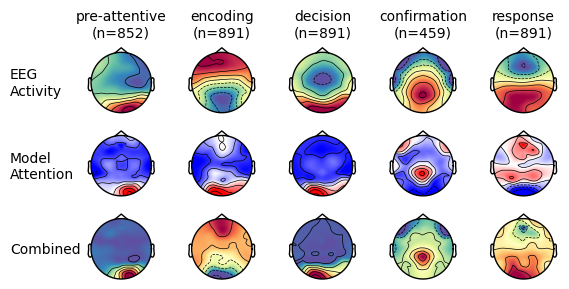

In [11]:
plot_max_activation_per_label(attributions, positions)

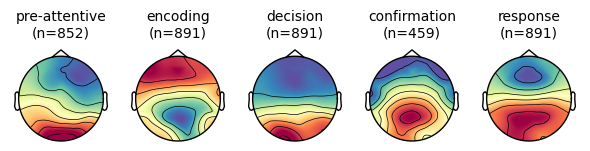

In [15]:
plot_mean_activation_per_label(attributions, positions)

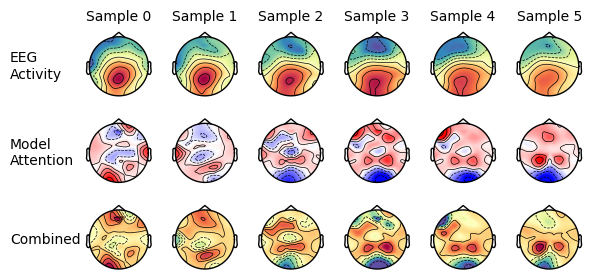

In [18]:
plot_single_trial_activation(attributions.isel(index=1), positions)

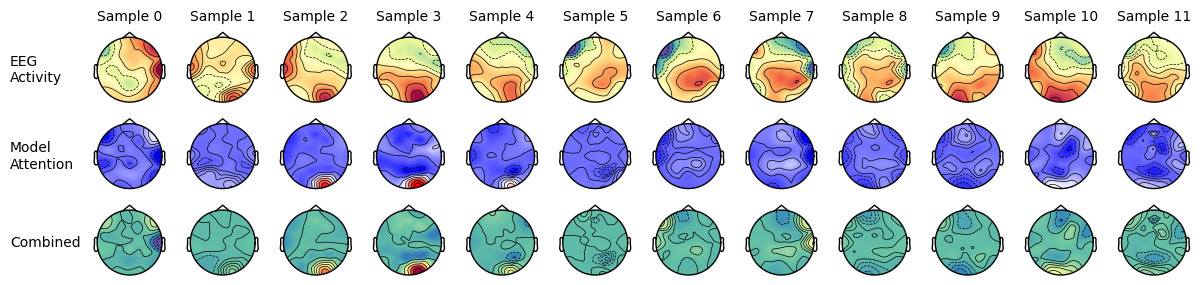

In [19]:
plot_single_trial_activation(attributions.isel(index=3), positions)

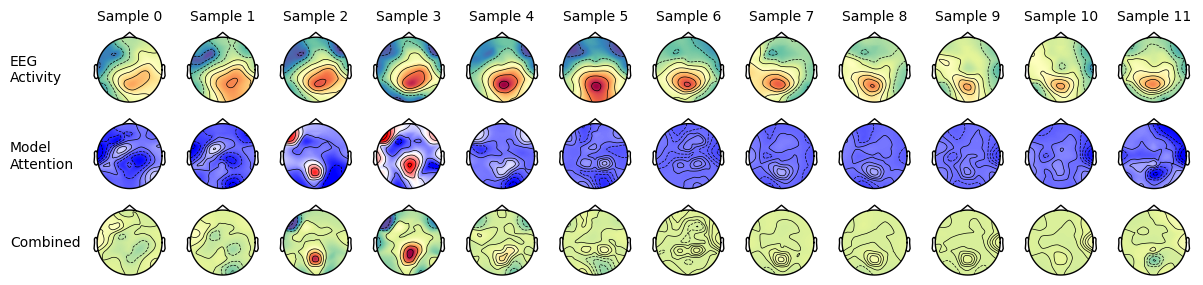

In [20]:
plot_single_trial_activation(attributions.isel(index=5), positions)

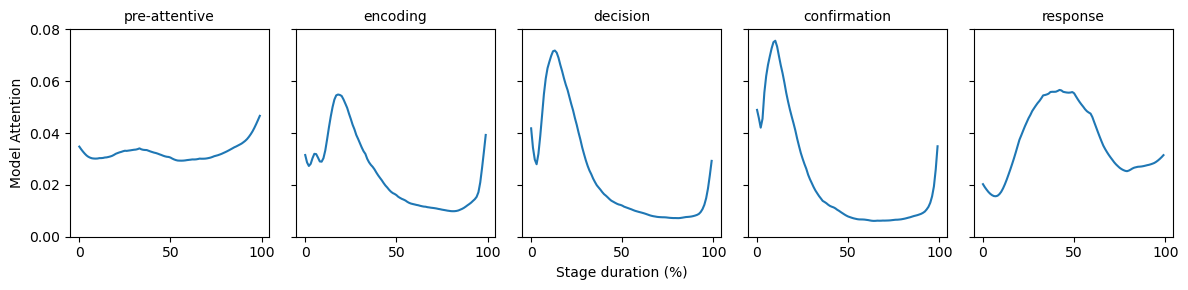

In [27]:
plot_model_attention_over_stage_duration(attributions)